# Misc

Stuff I want to teach, but there really isn't time to do it right and it is not needed for the course really.

- [Image Segmentation](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html#watershed)

In [3]:
%matplotlib inline 

from __future__ import print_function
from __future__ import division
import cv2         # opencv itself
import numpy as np # matrix manipulations

from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

## Image Segmentation with Watershed Algorithm

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys. You start filling every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys, obviously with different colors will start to merge. To avoid that, you build barriers in the locations where water merges. You continue the work of filling water and building barriers until all the peaks are under water. Then the barriers you created gives you the segmentation result. This is the “philosophy” behind the watershed. You can visit the [CMM](http://cmm.ensmp.fr/~beucher/wtshed.html) webpage on watershed to understand it with the help of some animations.

But this approach gives you oversegmented result due to noise or any other irregularities in the image. So OpenCV implemented a marker-based watershed algorithm where you specify which are all valley points are to be merged and which are not. It is an interactive image segmentation. What we do is to give different labels for our object we know. Label the region which we are sure of being the foreground or object with one color (or intensity), label the region which we are sure of being background or non-object with another color and finally the region which we are not sure of anything, label it with 0. That is our marker. Then apply watershed algorithm. Then our marker will be updated with the labels we gave, and the boundaries of objects will have a value of -1.

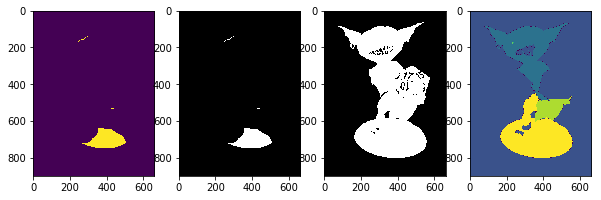

In [3]:
# img = cv2.imread('coins.jpg')
img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# boundries are marked as -1
markers = cv2.watershed(img,markers)
# img[markers == -1] = [255,0,0]

plt.subplot(1,4,1)
plt.imshow(sure_fg)

plt.subplot(1,4,2)
plt.imshow(sure_fg, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(thresh, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(markers)

len(markers)==900


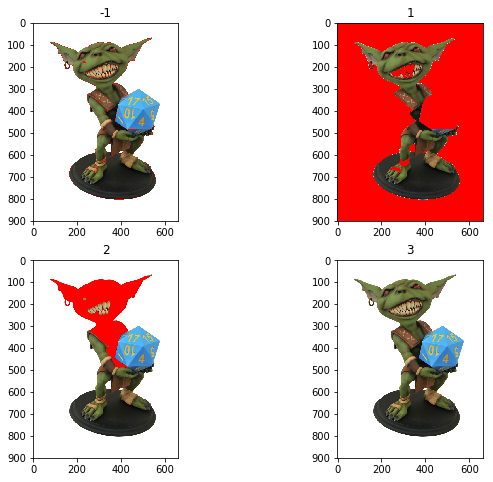

In [4]:
markers = cv2.watershed(img,markers)
print('len(markers)=={}'.format(len(markers)))
# img[markers == 1] = [255,0,0]

cimg = img.copy()
cimg[markers == -1] = [255,0,0]
plt.subplot(2,2,1)
plt.imshow(cimg)
plt.title(-1)

for i in range(1, 4):
    cimg = img.copy()
    cimg[markers == i] = [255,0,0]
    plt.subplot(2, 2, i+1)
    plt.imshow(cimg)
    plt.title(i)

# Color Quantinization

Reducing the number of colors in an image can be useful. Image you are trying to detect and maybe track the color red. Unfortunately there are a lot of different RGB (or HSV or whatever) numerical discriptions for what someone would call red. Sometimes it is nice to reduce all of those possible values down to just a few and then try to detect one of those colors. 

Unfortunately this is a little slow because of kmeans. :(

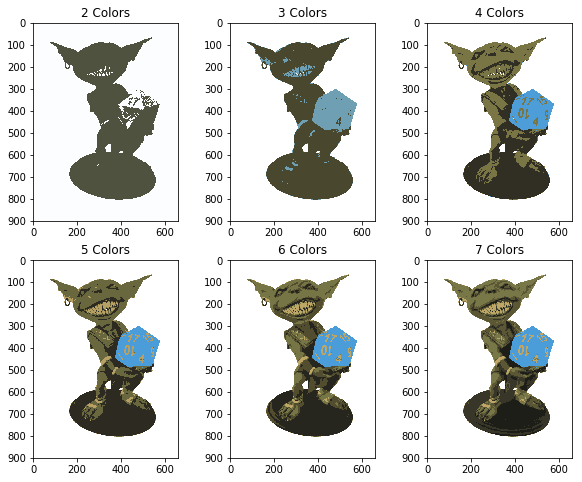

In [5]:
def quantize(img, K):
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for k in range(2,8):
    qimg = quantize(img, k)
    plt.subplot(2, 3, k-1)
    plt.imshow(qimg)
    plt.title('{} Colors'.format(k))

In [6]:
from mpl_toolkits.mplot3d import Axes3D

img = cv2.imread('dnd.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
K = 6
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# print(label)

A = Z[label.ravel()==0] # every pt with label zero, put in A
B = Z[label.ravel()==1]
C = Z[label.ravel()==2]
D = Z[label.ravel()==3]
E = Z[label.ravel()==4]
F = Z[label.ravel()==5]

print(A)
print(A.shape)
print(len(A))
print(center)

# Plot the data
# plt.subplot(111, projection='3d')
# plt.scatter(A[:,1],A[:,2])
# plt.scatter(A[:,0],A[:,1], A[:,2])
# plt.scatter(B[:,0],B[:,1], B[:,2])
# plt.scatter(C[:,0],C[:,1],C[:,2])
# plt.scatter(D[:,0],D[:,1],D[:,2])
# plt.scatter(E[:,0],E[:,1],E[:,2])
# plt.scatter(F[:,0],F[:,1],F[:,2])
# plt.scatter(center[:,0],center[:,1], center[:,2],s = 80,c = 'y', marker = 's')
# plt.scatter(center[:,0],center[:,1], center[:,2],c = 'y', marker = 's')
# plt.xlabel('Blue')
# plt.ylabel('Green')
# plt.title('6 Colors')
# plt.grid(True);

[[ 150.    1.  255.]
 [ 150.    1.  255.]
 [ 150.    1.  255.]
 ..., 
 [  90.    1.  255.]
 [ 105.    2.  255.]
 [ 120.    1.  255.]]
(6807, 3)
6807
[[  1.21023506e+02   4.37079477e+00   2.53299255e+02]
 [  7.82521904e-01   1.96539491e-01   2.55620697e+02]
 [  9.51955185e+01   1.70377838e+02   2.18778198e+02]
 [  2.80865822e+01   1.25028206e+02   7.63877029e+01]
 [  3.79599037e+01   3.52463493e+01   4.14845543e+01]
 [  2.99111004e+01   1.14115875e+02   1.35344833e+02]]


In [7]:
print(A[:,0].min(), A[:,0].max())
print(A[:,1].min(), A[:,1].max())
print(A[:,2].min(), A[:,2].max())

59.0 176.0
1.0 85.0
124.0 255.0


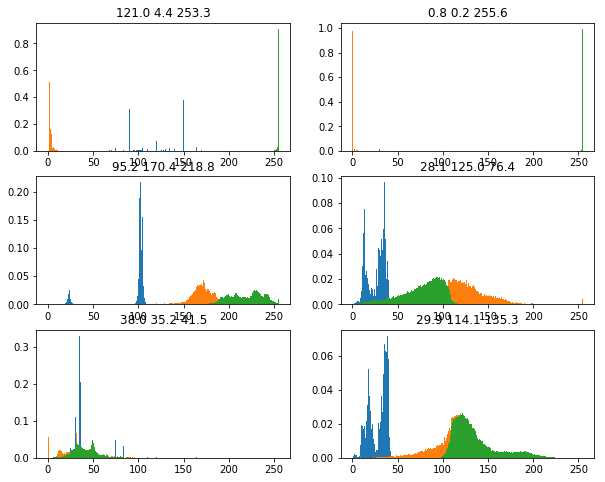

In [8]:
# For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]
for i, (h, c) in enumerate(zip([A,B,C,D,E,F], center)):
    plt.subplot(3,2,i+1)
    # rgb
#     plt.hist(h[:,0],256,[0,255], normed=True)
#     plt.hist(h[:,1],256,[0,255], normed=True)
#     plt.hist(h[:,2],256,[0,255], normed=True)
    # hsv
    plt.hist(h[:,0],180,[0,179], normed=True)
    plt.hist(h[:,1],256,[0,255], normed=True)
    plt.hist(h[:,2],256,[0,255], normed=True)
    plt.title('{:.1f} {:.1f} {:.1f}'.format(*c))
                         
# plt.hist(B,256,[0,256], normed=True)
# plt.hist(C,256,[0,256], normed=True)
# plt.hist(D,256,[0,256], normed=True)
# # plt.hist(E,256,[0,256], normed=True)
# plt.hist(F,256,[0,256], normed=True)
plt.show();

In [9]:
center[0]

array([ 121.02350616,    4.37079477,  253.29925537], dtype=float32)

Let's try another way. RBG is not a linear space and colors that are similar in appearance are not always next to each other. By switching to HSV, we are now in a cylindrical colorspace where colors are continous.

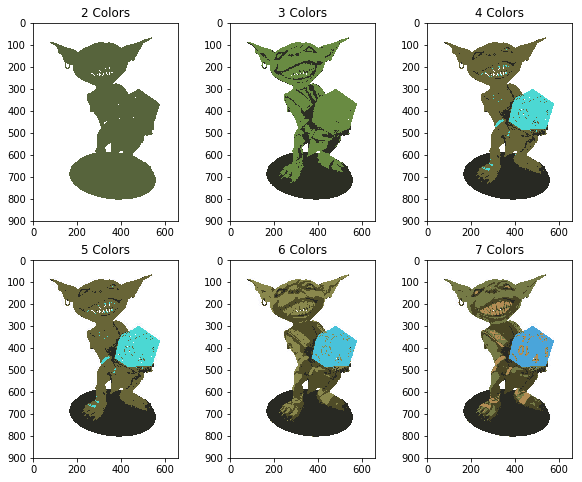

In [10]:
def quantize(img, K):
    # reshape (width, height, colors) to (width*height, colors)
    # the image is just a long array of pixels now
    Z = img.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return res2

img = cv2.imread('dnd.jpg')
# convert to a linear color space
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

for k in range(2,8):
    qimg = quantize(img, k)
    plt.subplot(2, 3, k-1)
    qimg = cv2.cvtColor(qimg, cv2.COLOR_HSV2RGB)
    plt.imshow(qimg)
    plt.title('{} Colors'.format(k))

In [11]:
# what does the reshape do?
a = np.zeros((10,10,3))
print(a.shape)
b = a.reshape((-1,3))
print(b.shape)
print(a.flatten().shape)

# now we have 3 color planes but we put all pixels
# in a row that we can sort/operate on

(10, 10, 3)
(100, 3)
(300,)


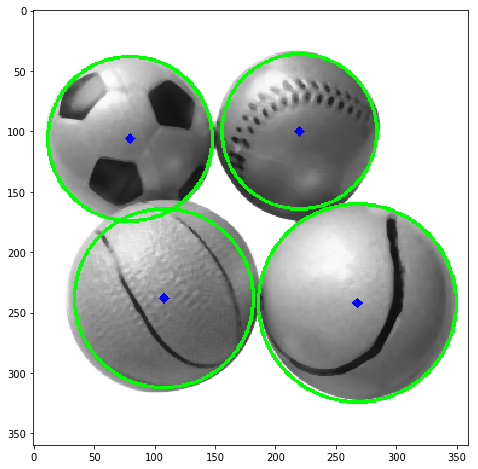

In [4]:
# Move some place else!!!

img = cv2.imread('balls.jpg',0)
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
circles = cv2.HoughCircles(
    img,
    cv2.HOUGH_GRADIENT,
    1,  # dp - accumulator has same resolution as image
    20, # min dist between circle centers
    param1=50,  # Upper threshold for the internal Canny edge detector
    param2=90,  # Threshold for center detection, smaller means more false positives
    minRadius=50,  # circle radius
    maxRadius=300)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
plt.imshow(cimg);